# Assignment #5: Capstone Project

## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

![SVHN overview image](data/svhn_examples.jpg)

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy.io import loadmat
from scipy.misc import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [61]:
# TF2 eager execution seems to cause issues in Jupyter (mutation?)
tf.compat.v1.disable_eager_execution()

## 1. Inspect and preprocess the dataset

* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.

* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.

* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._

* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

### Load data

In [62]:
def load_data():
    train = loadmat('data/train_32x32.mat')
    test = loadmat('data/test_32x32.mat')
    
    (x_train, y_train) = train['X'], train['y']
    (x_test, y_test) = test['X'], test['y']

    # Reorder axes
    x_train = np.moveaxis(x_train, -1, 0)
    x_test = np.moveaxis(x_test, -1, 0)
    
    # Change label [10] to [0]
    y_train[y_train == 10] = 0
    y_test[y_test == 10] = 0
    
    return (x_train, y_train), (x_test, y_test)

(orig_train_images, train_labels), (orig_test_images, test_labels) = load_data()

### Show 10 random images with labels

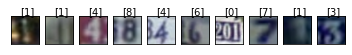

In [63]:
def show_10_random_images(test_images, test_labels, cmap=None):
    num_samples = 10
    num_images = test_images.shape[0]
    random_inx = np.random.choice(num_images, num_samples)

    random_images = test_images[random_inx,:,:,:]
    random_labels = test_labels[random_inx]

    fig, axes = plt.subplots(1, num_samples)

    for i in range(num_samples):
        axes[i].imshow(random_images[i, ...], cmap=cmap)
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
        axes[i].text(10., -1.5, f'{random_labels[i]}')  

    plt.show()

show_10_random_images(orig_test_images, test_labels)

### Convert images to grayscale

In [64]:
def convert_images_to_grayscale(train_images, test_images):
    gray_train_images = train_images.mean(axis=-1, keepdims=True) / 255
    gray_test_images = test_images.mean(axis=-1, keepdims=True) / 255
    return (gray_train_images, gray_test_images)
    
train_images, test_images = convert_images_to_grayscale(orig_train_images, orig_test_images)

### Show 10 random grayscale images with labels

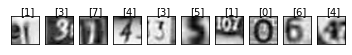

In [65]:
show_10_random_images(test_images, test_labels, cmap=plt.get_cmap('gray'))

## 2. MLP neural network classifier

* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 

* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._

* Print out the model summary (using the summary() method)

* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 

* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.

* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).

* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.

* Compute and display the loss and accuracy of the trained model on the test set.

### Build model

In [66]:
def get_mlp_model(input_shape):
    return Sequential([
        Flatten(input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])

### Compile and train model

In [67]:
def compile_model(model):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [68]:
def train_model(model, train_images, train_labels, test_images, test_labels, checkpoint_path):    
    checkpoint = ModelCheckpoint(filepath=checkpoint_path, frequency='epoch', save_weights_only=True, verbose=0)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)
    callbacks = [checkpoint, early_stopping]
    return model.fit(train_images, train_labels, epochs=30, validation_data=(test_images, test_labels), batch_size=64, callbacks=callbacks, verbose=1)

### Plot learning

In [69]:
def plot_learning(history):
    frame = pd.DataFrame(history.history)
    acc_plot = frame.plot(y="accuracy", title="Accuracy vs Epochs", legend=False)
    acc_plot.set(xlabel="Epochs", ylabel="Accuracy")
    acc_plot = frame.plot(y="loss", title="Loss vs Epochs", legend=False)
    acc_plot.set(xlabel="Epochs", ylabel="Loss")

### Evaluate model performance against test data

In [70]:
def evaluate_model(model, test_images, test_labels):
    test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
    print(f"Test loss: {test_loss}")
    print(f"Test accuracy: {test_accuracy}")

### Run

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 64)                65600     
_________________________________________________________________
dense_46 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_47 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_48 (Dense)             (None, 10)                650       
Total params: 74,570
Trainable params: 74,570
Non-trainable params: 0
_________________________________________________________________
Train on 73257 samples, validate on 26032 samples
Epoch 1/30
73257/73257 [==============================] - 3s 46us

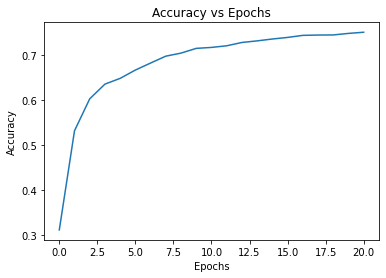

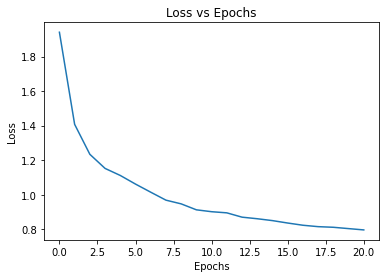

In [71]:
mlp_model = get_mlp_model(train_images[0].shape)
mlp_model.summary()
compile_model(mlp_model)
mlp_history = train_model(mlp_model, train_images, train_labels, test_images, test_labels, checkpoint_path='checkpoints/mlp_checkpoint')
plot_learning(mlp_history)
evaluate_model(mlp_model, test_images, test_labels)

## 3. CNN neural network classifier

* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 

* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_

* The CNN model should use fewer trainable parameters than your MLP model.

* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.

* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.

* You should aim to beat the MLP model performance with fewer parameters!

* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.

* Compute and display the loss and accuracy of the trained model on the test set

### Build model

In [72]:
def get_cnn_model(input_shape):
    return Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((3, 3)),
        BatchNormalization(),
        Dropout(0.3),
        Flatten(),
        Dense(10, activation='softmax')
    ])

### Run

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 10, 10, 16)        64        
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 10, 16)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 10)                16010     
Total params: 16,234
Trainable params: 16,202
Non-trainable params: 32
________________________________________________

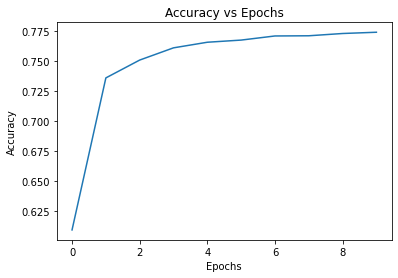

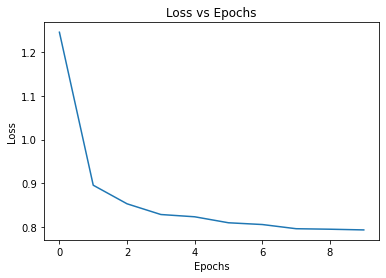

In [73]:
cnn_model = get_cnn_model(train_images[0].shape)
cnn_model.summary()
compile_model(cnn_model)
cnn_history = train_model(cnn_model, train_images, train_labels, test_images, test_labels, checkpoint_path='checkpoints/cnn_checkpoint')
plot_learning(cnn_history)
evaluate_model(cnn_model, test_images, test_labels)

## 4. Get model predictions

* Load the best weights for the MLP and CNN models that you saved during the training run.

* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.

* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [74]:
def plot_predictions(model, test_images, test_labels):
    num_test_images = test_images.shape[0]

    random_inx = np.random.choice(num_test_images, 5)
    random_test_images = test_images[random_inx, ...]
    random_test_labels = test_labels[random_inx, ...]

    predictions = model.predict(random_test_images)

    fig, axes = plt.subplots(5, 2, figsize=(16, 12))
    fig.subplots_adjust(hspace=0.4, wspace=-0.2)

    for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
        axes[i, 0].imshow(np.squeeze(image), cmap=plt.get_cmap('gray'))
        axes[i, 0].get_xaxis().set_visible(False)
        axes[i, 0].get_yaxis().set_visible(False)
        axes[i, 0].text(10., -1.5, f'Digit {label}')
        axes[i, 1].bar(np.arange(len(prediction)), prediction)
        axes[i, 1].set_xticks(np.arange(len(prediction)))
        axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")

    plt.show()

### MLP model

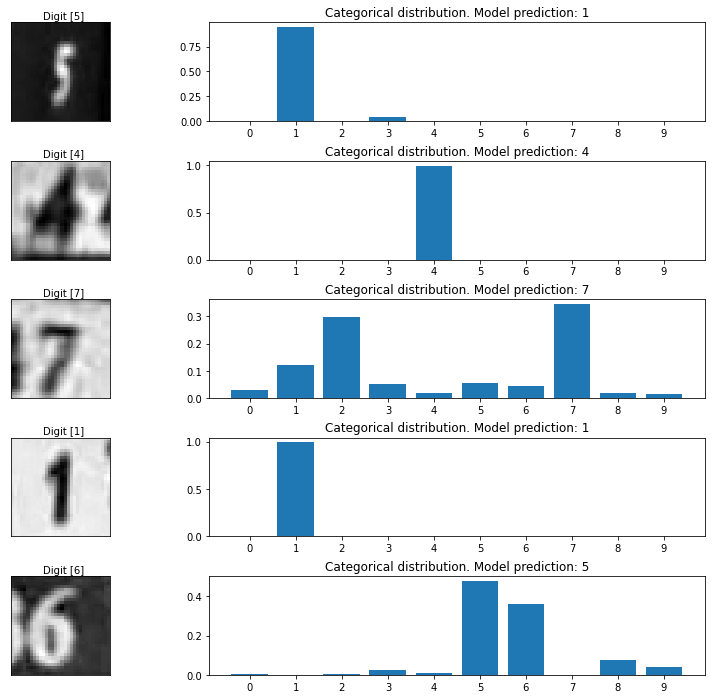

In [75]:
new_mlp_model = get_mlp_model(train_images[0].shape)
mlp_checkpoint_path = 'checkpoints/mlp_checkpoint'
new_mlp_model.load_weights(mlp_checkpoint_path)
plot_predictions(new_mlp_model, test_images, test_labels)

### CNN model

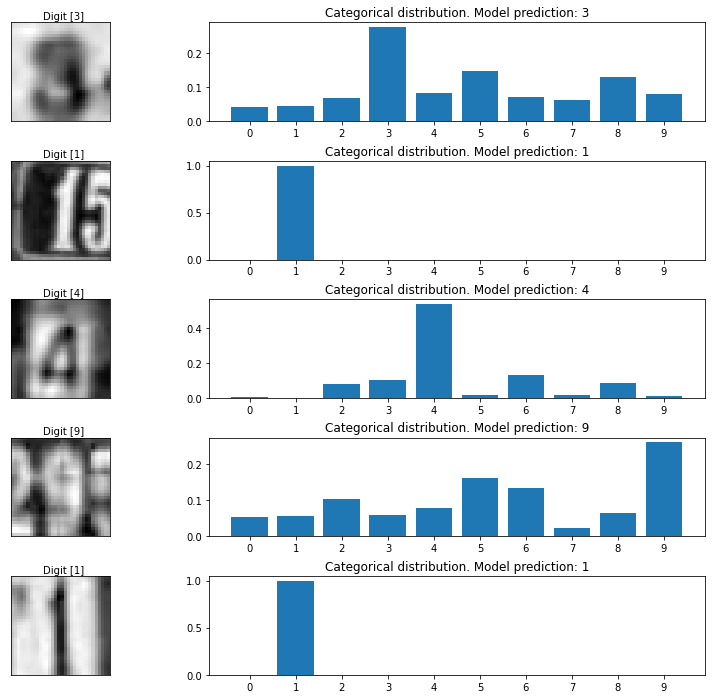

In [76]:
new_cnn_model = get_cnn_model(train_images[0].shape)
cnn_checkpoint_path = 'checkpoints/cnn_checkpoint'
new_cnn_model.load_weights(cnn_checkpoint_path)
plot_predictions(new_cnn_model, test_images, test_labels)